In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from evolvepro.src.data import load_dms_data
from evolvepro.src.evolve import directed_evolution_simulation
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
import pca_visualisation

In [2]:
# running random forest and saving iterative predictions

#TODO: make this into a function

# load dataset
dataset_name = "jones"
model_name = "esm1b_t33_650M_UR50S"
embeddings_path = "output/dms/embeddings"
labels_path = "output/dms/labels"
embeddings_file_type = "csv"
embeddings_type_pt = "average"
embeddings, labels = load_dms_data(dataset_name, model_name, embeddings_path, labels_path, embeddings_file_type, embeddings_type_pt)

output_dir = "output/embedding_projections_test" 

all_predictions = []

iteration_old = None
for iter in range(0, 10):
    if iter == 0:
        # first iteration: randomly select mutants
        selected_variants = np.random.choice(
            labels.loc[labels['variant'] != 'WT', 'variant'],
            size=10, # number of mutants per round
            replace=False
        )
        iteration_old = pd.DataFrame({'iteration': iter, 'variant': selected_variants})
    else:
        # subsequent iterations: train Random Forest and predict on unselected variants
        selected_variants = set(iteration_old['variant'])

        # select embeddings and labels based on variant names
        selected_mask = embeddings.index.isin(selected_variants)

        # split data into training and prediction sets
        X_train = embeddings[selected_mask]
        y_train = labels.loc[selected_mask, 'activity']

        X_predict = embeddings[~selected_mask]
        variants_to_predict = X_predict.index.tolist()

        # train random forest model
        model = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=None, min_samples_split=2,
                                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0,
                                      max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False,
                                      n_jobs=None, random_state=1, verbose=0, warm_start=False, ccp_alpha=0.0,
                                      max_samples=None)
        model.fit(X_train, y_train)

        # make predictions for unseen mutations - used for next step calculations
        predictions = model.predict(X_predict)

        # save predictions 
        df_predictions = pd.DataFrame({
            'iteration': iter,
            'variant': variants_to_predict,
            'predicted_activity': predictions
        })
    
        # predict all mutations instead of just unseen ones, and save to output dataframe
        predict_all = model.predict(embeddings)
        all_variants = embeddings.index.tolist()
        all_predictions_df = pd.DataFrame({
            'iteration': iter,
            'variant': all_variants,
            'predicted_activity': predict_all
        })

        # save prediction for this iteration
        #all_predictions.append(df_predictions)
        all_predictions.append(all_predictions_df)

        # select the top variants for next iteration
        top_variants = df_predictions.sort_values(by='predicted_activity', ascending=False)
        selected_variants = top_variants.head(10)['variant'].tolist()

        # update iteration_old with the selected variants
        iteration_old = pd.concat(
            [iteration_old, pd.DataFrame({'iteration': iter, 'variant': selected_variants})],
            ignore_index=True
        )

final_predictions = pd.concat(all_predictions, ignore_index=True)

output_file = os.path.join(output_dir, "all_iterations_predictions.csv")
final_predictions.to_csv(output_file, index=False)

Embeddings and labels are aligned


In [5]:
# convert the final predictions into an appropriate format
iteration_predictions_df = pd.read_csv("output/embedding_projections_test/all_iterations_predictions.csv")

final_iteration_data = iteration_predictions_df[iteration_predictions_df["iteration"] == 9].drop(columns=["iteration"])
final_iteration_data.to_csv(os.path.join(output_dir, "final_iteration_data.csv"), index=False)

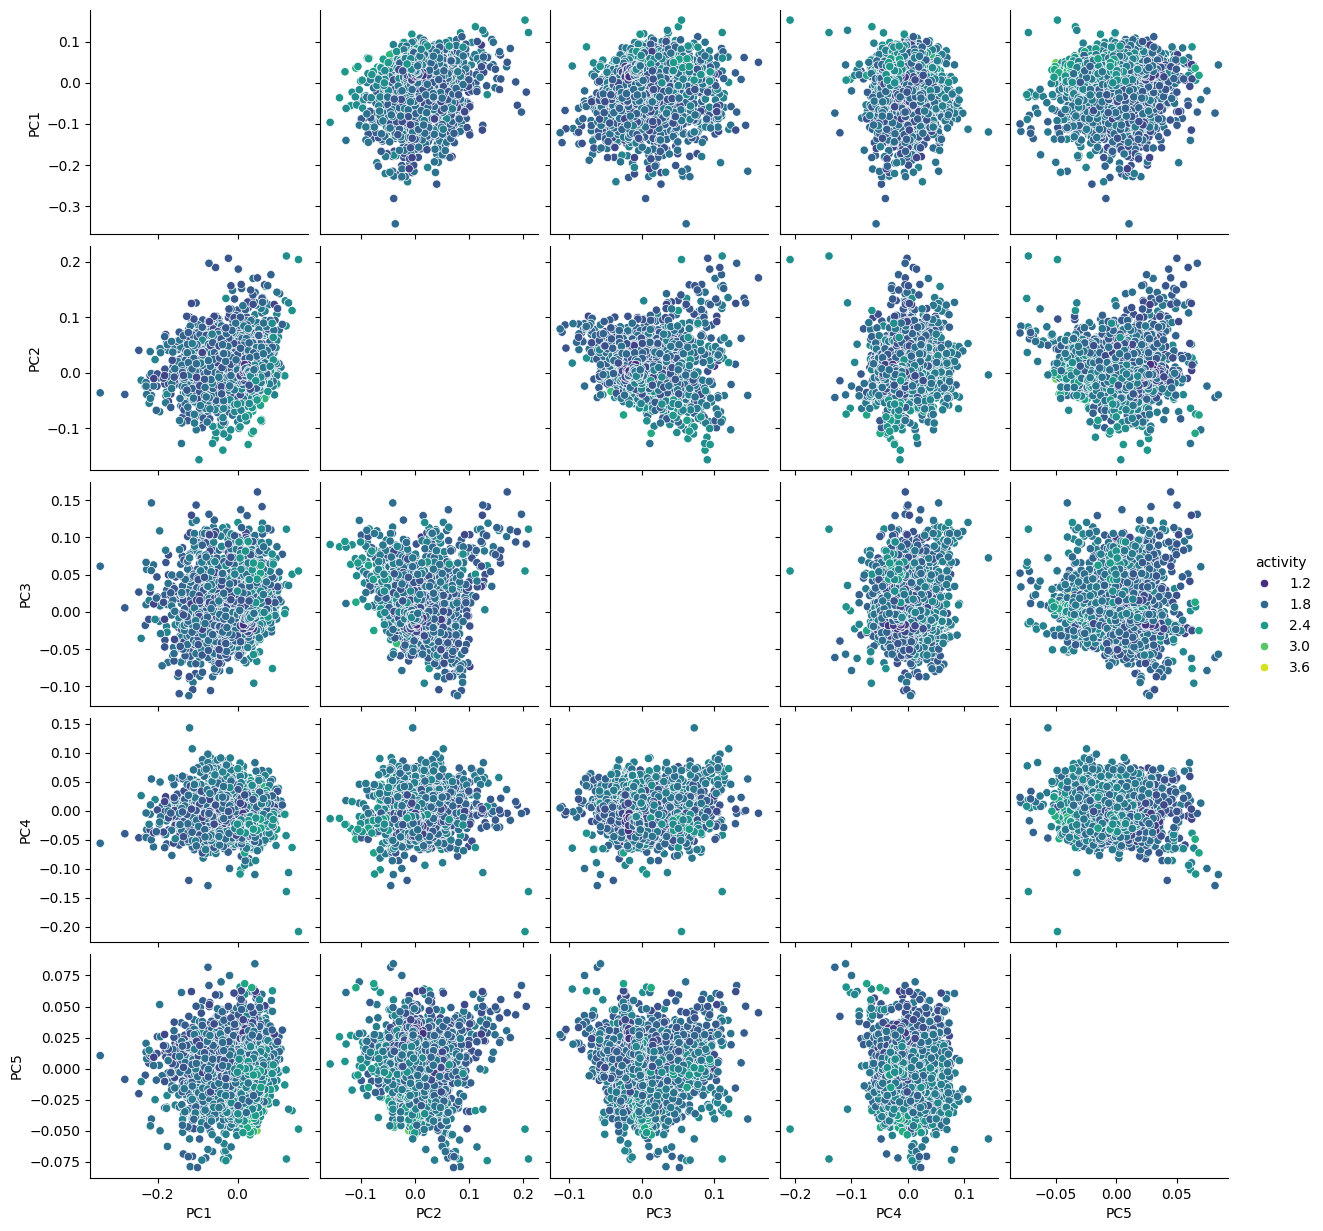

In [6]:
pca = pca_visualisation.Create_PCA(
    embedding_path = "output/dms/embeddings/jones_esm1b_t33_650M_UR50S.csv",
    labels_path = "output/embedding_projections_test/final_iteration_data.csv",
    label_name="predicted_activity",
    n_dims=5
)

pca.visualise_labels()